In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import statistics
%matplotlib inline

In [2]:
PATH_TO_SUBSIDIES = r'data\Данные Меры поддержки на сайте ГИСП.csv'
PATH_TO_ALLOCATORS = r'data\Реестр субсидий\allocators.json'
PATH_TO_RECIEVERS = r'data\Реестр субсидий\receivers.json'

ENCODING = 'cp1251'

In [17]:
subsidies = pd.read_csv(PATH_TO_SUBSIDIES, sep=';', encoding=ENCODING)
subsidies.head()

,"""ID""","""URL""","""SMALL_NAME""","""FULL_NAME""","""NUMBER_NPA""","""DATE_NPA""","""NPA_NAME""","""DESCRIPTION""","""PURPOSE""","""OBJECTIVE""",...,"""REQ_ZAYAVITEL""","""REQUEST_PROJECT""","""IS_SOFINANCE""","""DOLYA_ISOFINANCE""","""BUDGET_PROJECT""","""POKAZATEL_RESULT""","""TERRITORIAL_LEVEL""","""REGION_ID""","""RESPONS_STRUCTURE""","""ORG_ID"""
0,12447263,https://gisp.gov.ru/support-measures/list/1244...,Субсидия на возмещение части затрат субъектов ...,Субсидия на возмещение части затрат субъектов ...,№ 267-П,23.07.2018,Постановление Правительства РК от 23.07.2018 N...,При возмещении части затрат субъектов малого и...,NaN,Государственная поддержка субъектов малого и с...,...,На дату подачи документов для участия в конкур...,NaN,False,NaN,NaN,NaN,Региональный,Республика Карелия,РОИВ,NaN
1,12447262,https://gisp.gov.ru/support-measures/list/1244...,Субсидия на возмещение части затрат субъектов ...,Субсидия на возмещение части затрат субъектов ...,№ 267-П,23.07.2018,Постановление Правительства РК от 23.07.2018 N...,При возмещении части затрат субъектов малого и...,NaN,Государственная поддержка субъектов малого и с...,...,На дату подачи документов для участия в конкур...,NaN,False,NaN,NaN,NaN,Региональный,Республика Карелия,РОИВ,NaN
2,12447261,https://gisp.gov.ru/support-measures/list/1244...,Субсидия на возмещение части затрат субъектов ...,Субсидия на возмещение части затрат субъектов ...,№ 267-П,23.07.2018,Постановление Правительства РК от 23.07.2018 N...,При возмещении части затрат субъектов малого и...,NaN,Государственная поддержка субъектов малого и с...,...,На дату подачи документов для участия в конкур...,NaN,False,NaN,NaN,NaN,Региональный,Республика Карелия,РОИВ,NaN
3,12447260,https://gisp.gov.ru/support-measures/list/1244...,Субсидия на компенсацию части затрат субъектов...,Субсидия на компенсацию части затрат субъектов...,№ 267-П,23.07.2018,Постановление Правительства РК от 23.07.2018 N...,При компенсации части затрат субъектов малого ...,NaN,Государственная поддержка субъектов малого и с...,...,На дату подачи документов для участия в конкур...,NaN,False,NaN,NaN,NaN,Региональный,Республика Карелия,РОИВ,NaN
4,12447259,https://gisp.gov.ru/support-measures/list/1244...,Субсидия на компенсацию части затрат субъектов...,Субсидия на компенсацию части затрат субъектов...,№ 267-П,23.07.2018,Постановление Правительства РК от 23.07.2018 N...,При компенсации части затрат субъектов малого ...,NaN,Государственная поддержка субъектов малого и с...,...,На дату подачи документов для участия в конкур...,NaN,False,NaN,NaN,NaN,Региональный,Республика Карелия,РОИВ,NaN


In [3]:
types = {'h': np.int64,
        'i': np.int64,
        'j': np.int64}
dfs = pd.read_excel(r'data\orgs-clean.xlsx', dtype=types)
dfs.head()

,ОКВЭД2,"Вид деятельности, основной ТАСС","Вид деятельности, дополнительный ТАСС",Организационно правовая форма,Тип компании,Атрибуты предприятия,Отрасль,ОГРН,ИНН,КПП,Регион
0,Производство элементов электронной аппаратуры ...,Производство элементов электронной аппаратуры ...,"Деятельность вспомогательная прочая, связанная...",НЕПУБЛИЧНЫЕ АКЦИОНЕРНЫЕ ОБЩЕСТВА [7026704],Организация [7026691],"Предприятие, оказывающее существенное влияние ...",Радиоэлектронная промышленность [258],1027700140930,7.735011e+09,773501001,Москва [3505]
1,Производство оружия и боеприпасов [27574],Производство оружия и боеприпасов [27575],Производство коммуникационного оборудования [2...,АКЦИОНЕРНЫЕ ОБЩЕСТВА [7026719],Организация [7026691],Системообразующее предприятие [8690579] / Орга...,Радиоэлектронная промышленность [258],1027739001993,7.731084e+09,997450001,Москва [3505]
2,Производство оружия и боеприпасов [27575],Производство оружия и боеприпасов [27575],Лесоводство и прочая лесохозяйственная деятель...,НЕПУБЛИЧНЫЕ АКЦИОНЕРНЫЕ ОБЩЕСТВА [7026704],Организация [7026691],Организация ОПК [8780665] / Системообразующее ...,Промышленность боеприпасов и спецхимии [256],1127154020311,7.105516e+09,710501001,Тульская область [3535]
3,Производство красителей и пигментов [27354] / ...,Производство оружия и боеприпасов [27575],Производство красителей и пигментов [27354] / ...,ФЕДЕРАЛЬНЫЕ ГОСУДАРСТВЕННЫЕ УНИТАРНЫЕ ПРЕДПРИЯ...,Организация [7026691],Одобрено Минпромторгом России [8690599] / Орга...,Промышленность боеприпасов и спецхимии [256],1034700561895,4.703010e+09,470350001,Ленинградская область [3500]
4,Производство коммуникационного оборудования [2...,Научные исследования и разработки в области ес...,Производство коммуникационного оборудования [2...,НЕПУБЛИЧНЫЕ АКЦИОНЕРНЫЕ ОБЩЕСТВА [7026704],Организация [7026691],Системообразующее предприятие [8690579] / Орга...,Радиоэлектронная промышленность [258],1037730020844,7.730170e+09,773001001,Москва [3505]


In [99]:
dfs.shape

(11387, 11)

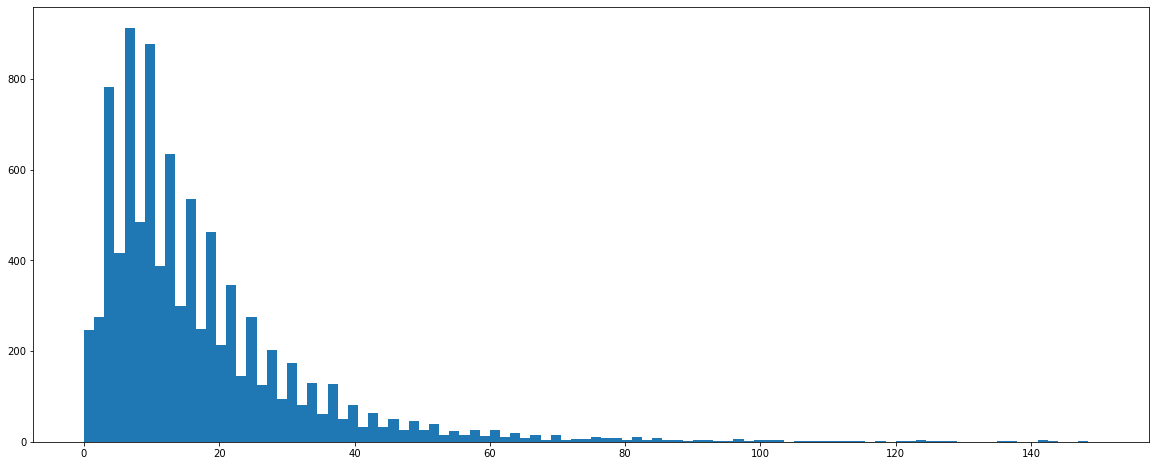

In [80]:
tass_set = set()
maximum = 0
arr = []
for val in dfs['Вид деятельности, дополнительный ТАСС'].dropna():
    tass = val.split(' / ')
    if len(tass) > maximum:
        maximum = len(tass)
    arr.append(len(tass))
    for t in tass:
        tass_set.add(t.strip())
for val in dfs['Вид деятельности, основной ТАСС'].dropna():
    tass_set.add(val.strip())

In [83]:
okved_set = set()
maximum = 0
arr = []
for val in dfs['ОКВЭД2'].dropna():
    okved = val.split(' / ')
    if len(okved) > maximum:
        maximum = len(okved)
    arr.append(len(okved))
    for t in okved:
        okved_set.add(t.strip())

In [87]:
attr_set = set()
maximum = 0
arr = []
for val in dfs['Атрибуты предприятия'].dropna():
    attr = val.split(' / ')
    if len(attr) > maximum:
        maximum = len(attr)
    arr.append(len(attr))
    for t in attr:
        attr_set.add(t.strip())

In [95]:
otrasl_set = set()
maximum = 0
arr = []
for val in dfs['Отрасль'].dropna():
    otrasl = val.split(' / ')
    if len(otrasl) > maximum:
        maximum = len(otrasl)
    arr.append(len(otrasl))
    for t in otrasl:
        otrasl_set.add(t.strip())

In [96]:
statistics.median(arr)

1

In [97]:
maximum

10

In [98]:
len(list(otrasl_set))

59

In [90]:
len(list(attr_set))

8

In [85]:
len(list(okved_set))

908

In [82]:
len(list(tass_set))

2140

In [21]:
ogrns = set(dfs['ОГРН'])
inns = set(dfs['ИНН'])
kpps = set(dfs['КПП'])

In [43]:
def load_json(path):
    DUMPS = []
    with open(path, 'r', encoding="utf8") as f:
        for data in f:
            dump = json.loads(data)
            inn_correct = False
            inn_correct = (len(dump['receiver'][0]['inn']) > 0 and np.int64(dump['receiver'][0]['inn']) in inns)
            if (len(dump['plans']) + len(dump['plansSubject']) + len(dump['addagreement'])) != 0 and inn_correct: 
                DUMPS.append(dump)
    return DUMPS

In [5]:
del D2

NameError: name 'D2' is not defined

In [44]:
D2 = []
for path in os.listdir(r'data\dumps'):
    p = os.path.join(r'data\dumps', path)
    D2 += load_json(p)

In [45]:
len(D2)

14198

In [76]:
plans_set = set()
planssubject_set = set()
addagreement_set = set()
faip_set = set()
targets_set = set()
for i in range(len(D2)):
    dump = D2[i]
    if len(dump['plans']) != 0:
        plans_set.add(i)
    if len(dump['plansSubject']) != 0:
        planssubject_set.add(i)
    if len(dump['addagreement']) != 0:
        addagreement_set.add(i)
    if len(dump['faip']) != 0:
        faip_set.add(i)
    

In [77]:
KBKS = faip_set.union(plans_set, addagreement_set, planssubject_set)
len(KBKS)

381667

In [80]:
t4 = []
for i in KBKS:
    dump = D2[i]
    if dump['grbs']['fullName'] == 'МИНИСТЕРСТВО ПРОМЫШЛЕННОСТИ И ТОРГОВЛИ РОССИЙСКОЙ ФЕДЕРАЦИИ':
        t4.append(dump)
len(t4)

11247